# Input to Final Project
## Date resampling and model screening

### Imports

In [17]:
import os
import tpqoa
import numpy as np
import pandas as pd
from pylab import plt
plt.style.use('seaborn-v0_8')
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, QuantileTransformer  # Normalization

# Own classes and functions in external .py files
from financial_data import FinancialData  # Class: import/resample data
from data_pre_processing import DataPreProcessing # Class: preprocesses data
from qq_plot import create_qq_plot ## Function: QQ-plotting


from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, \
BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import mutual_info_classif, SelectKBest, f_classif


### Import historical data
Use the `FinancialData` class to create a dictionary (fd) containing financial data and trading cost

In [2]:
# User defined arguments for data import
symbol = 'EUR_USD'
start = '2023-01-01'
end = '2025-03-31'
base_url = 'https://raw.githubusercontent.com/mortenrosenloev/\
CPF-Final-Project/refs/heads/main/data/'
# Timeframes used for this study
timeframe = ['30min', '1h', '2h', '4h', '8h', '24h']

### Analyse data returns

#### QQ-plot of the log-returns to see if the different timeframes indicate different statistics.  
Using the function `create_qq_plot` we create subplots for each timeframe.  
We also evaluate whet data-normalization using `StandardScaler` (z-score) and `QuantileTransformer`does to the to the shape.

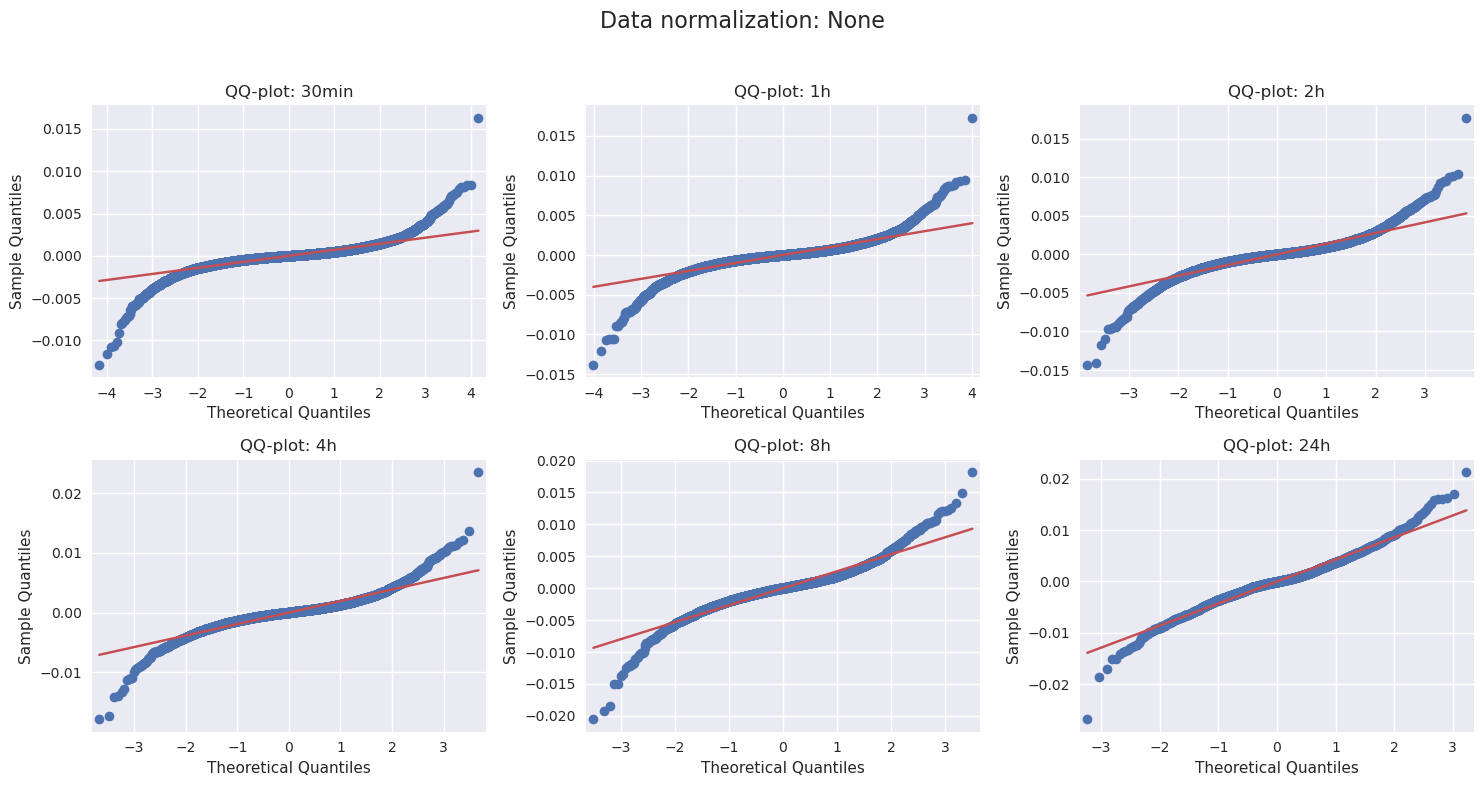

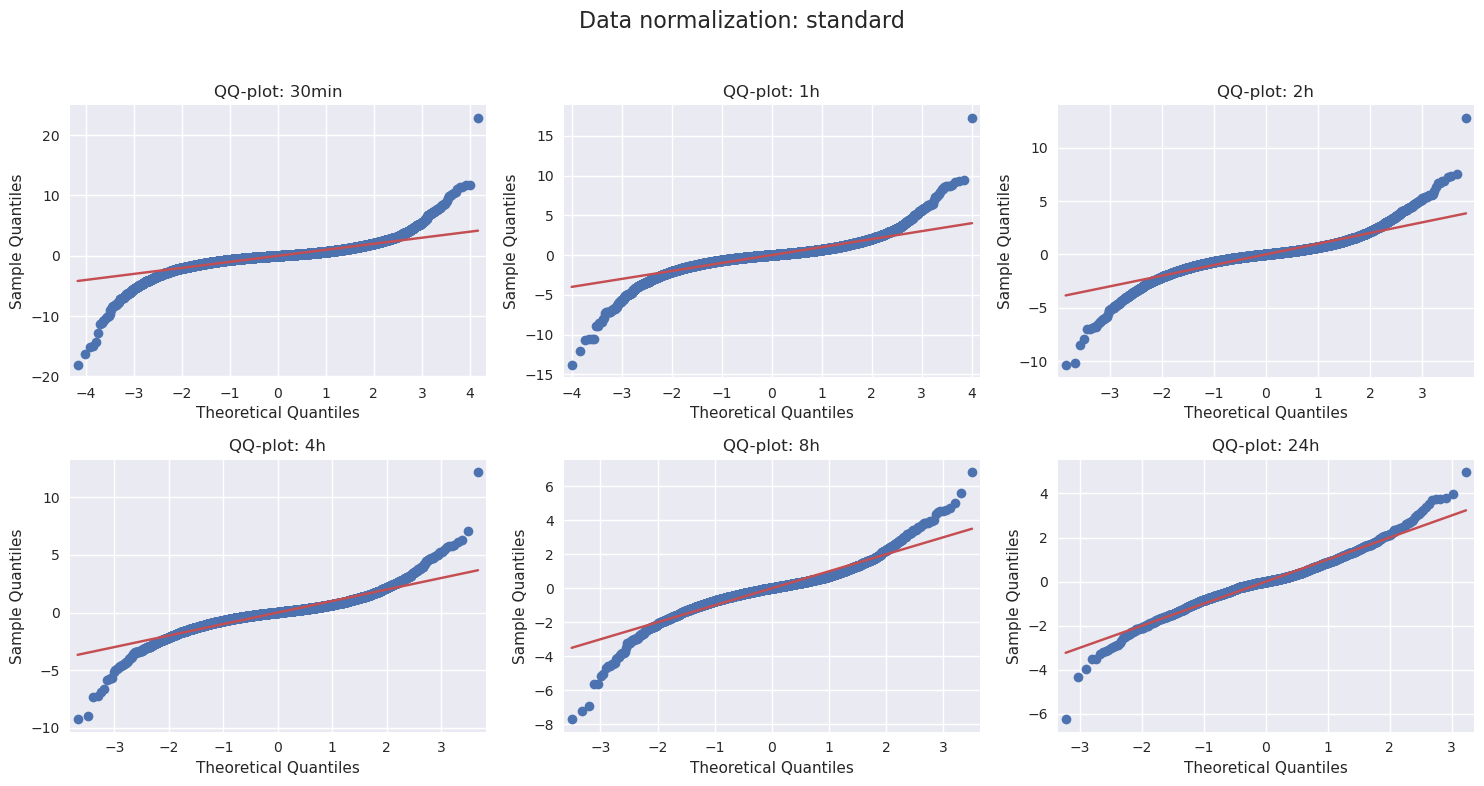

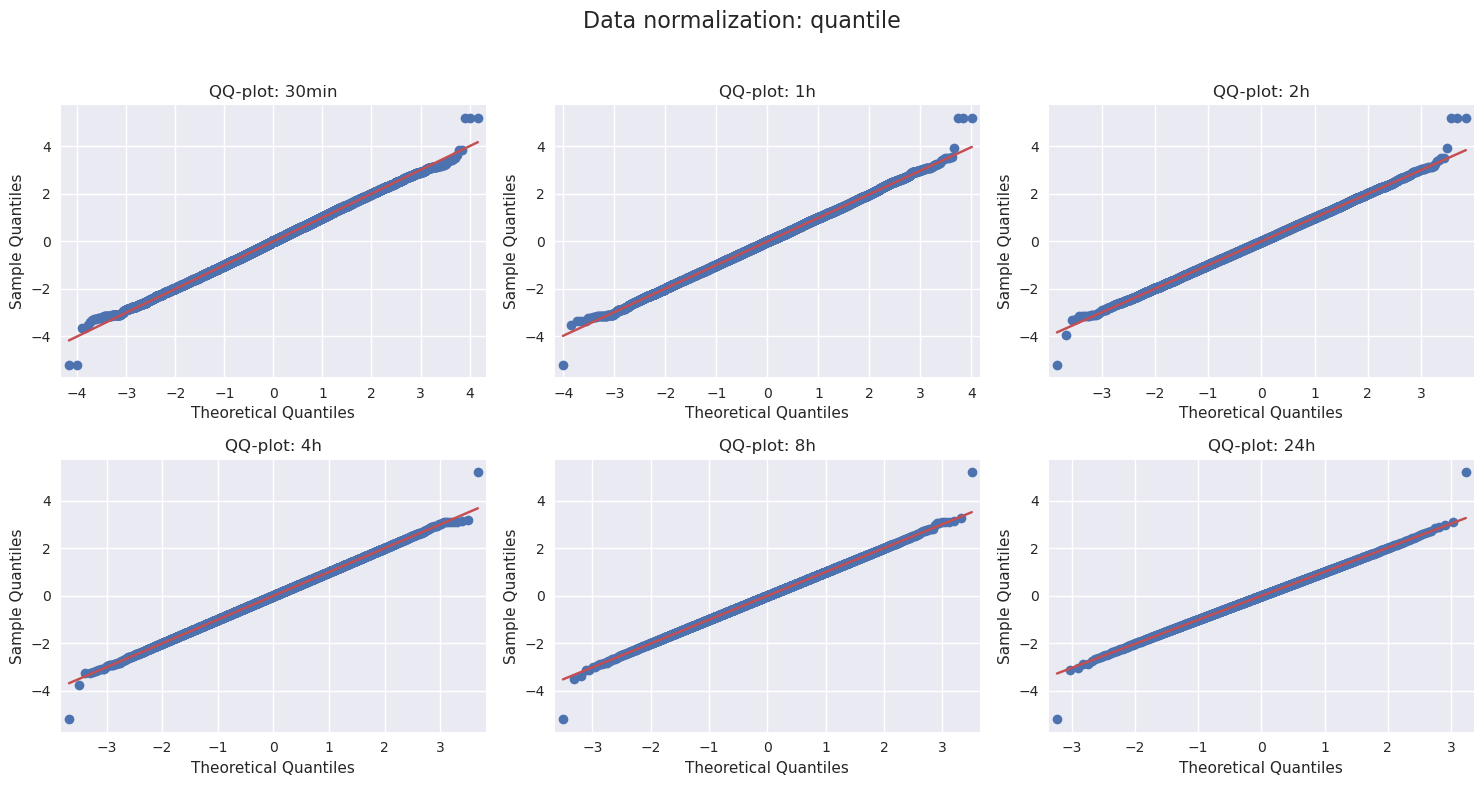

In [4]:
fd = {}  # instantiate an empty dictionary for the FinancialData
for tf in timeframe:
    fd[tf] = FinancialData(base_url, symbol=symbol, 
                           timeframe=tf, verbose=False)    
normalizers = [None, 'standard', 'quantile']
for norm in normalizers:
    create_qq_plot(fd, norm)

From the top plots we notice that the returns are nor normal distributes as they all have fat tails, and it is difficult to see any significant differences across the different timeframes.  
`StandardScaler`(z-score) does not change the shape of the curves but forces the distribution to a mean close to 0 and a standard devision around 1.  
`QuantileTransformer` forces the date to almost being normally dstributed, which may be an advantage for some ML/DNN models.  
Hence, the script biulds in the option to select normalization method for the data and features.

### Add Features

In [14]:
# Input for the DataPreProcessing class
# We use a fixed date for the train/test split since we work across multiple timeframes
timeframe = '30min'
start = '2023-01-01'
end = '2024-12-31'
tt_split = '2024-11-01'
bins = 5
clusters = 10
lags = 10
normalize = 'auto' # optiona are: ['auto', 'standard, 'quantile', robust', 'min-max']
tt_split = tt_split  # only used if rolling=False
rolling = False # use rolling train/test split
rolling_splits = 20 # number of rolling splits
max_train_size = None # max number of bars in train data set
test_size = 20 # number of bars in test data set
pca = None

In [15]:
master = DataPreProcessing(base_url, symbol,
                           start=start,
                           end=end,
                           timeframe=timeframe,
                    bins=bins,
                    clusters=clusters,
                    lags=lags,
                    normalize=normalize,
                    tt_split=tt_split,  # only used of rolling=False
                    rolling=rolling,       # use rolling train/test split
                    rolling_splits=rolling_splits,
                    max_train_size=max_train_size,
                    test_size=test_size,
                    pca=pca
                   )

In [23]:
X_train = master.X_train_norm
X_test = master.X_test_norm
y_train = master.y_train
y_test = master.y_test

### Screen different classifier-models

In [24]:
# Models 1 - 6:   Scikit-learn classifier models
# Model 7:        Scikit-learn neural network model
# Models 8 - 14:  BaggingClassifier models with different base-estimators
# Models 14 - 16: AbdBoostClassifier models with different base-estimators
models_1 = {
    'Model_1': LogisticRegression(max_iter=1000, random_state=100),
    'Model_2': GaussianNB(),
    'Model_3': KNeighborsClassifier(),
    'Model_4': DecisionTreeClassifier(random_state=100),
    'Model_5': RandomForestClassifier(random_state=100),
    'Model_6': SVC(random_state=100),
    'Model_7': MLPClassifier([128, 128], max_iter=2000, early_stopping=True,
                             random_state=100),
    'Model_8': BaggingClassifier(estimator=LogisticRegression(max_iter=1000,
                                                              random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_9': BaggingClassifier(estimator=GaussianNB(),
                                 random_state=100,
                                 n_estimators=10),
    'Model_10': BaggingClassifier(estimator=KNeighborsClassifier(),
                                 random_state=100,
                                 n_estimators=10),
    'Model_11': BaggingClassifier(estimator=
                                  DecisionTreeClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_12': BaggingClassifier(estimator=
                                  RandomForestClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_13': BaggingClassifier(estimator=SVC(random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_14': BaggingClassifier(estimator=MLPClassifier(
        [128, 128], max_iter=2000, early_stopping=True, random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_15': AdaBoostClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                random_state=100),
                                 random_state=100,
                                 n_estimators=10),
    'Model_16': AdaBoostClassifier(estimator=
                                   DecisionTreeClassifier(random_state=100),
                                 random_state=100,
                                 n_estimators=10)         }

In [ ]:
for model in models_1:
    class_model = models_1.get(model)
    name = model
    class_model.fit(X_train, y_train)
    y_pred = class_model.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f'Accuracy score for {name.ljust(10)} | Accuracy score: {acc:.4f}')